# Thermal Neural Networks (Pytorch example)

This jupyter notebook showcases how to utilize a thermal neural network (TNN) on an exemplary data set.
This example is more concise than the TF2 example and standalone (not utilizing the "aux" package) but lacks a few convenient mechanics in turn (e.g., validation set, early stopping, plotting helpers etc.)

The data set can be downloaded from [Kaggle](https://www.kaggle.com/wkirgsn/electric-motor-temperature).
It should be placed in `data/input/`.

In [2]:
import os
import argparse
import time
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
try:
    plt.style.use('seaborn-v0_8-talk')
except OSError:
    plt.style.use("seaborn-talk")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.jit as jit
from torch.nn import Parameter as TorchParam
from torch import Tensor
from typing import List, Tuple

## Data setup

In [3]:
path_to_csv=Path().cwd()/ 'data' / 'input' / 'measures_v2.csv'
data = pd.read_csv(path_to_csv)
target_cols = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

temperature_cols = target_cols + ['ambient', 'coolant']
test_profiles = [60, 62, 74]
train_profiles = [p for p in data.profile_id.unique() if p not in test_profiles]
profile_sizes = data.groupby('profile_id').agg('size')

# normalize
non_temperature_cols = [c for c in data if c not in temperature_cols + ['profile_id']]
data.loc[:, temperature_cols] /= 100 # deg C
data.loc[:, non_temperature_cols] /= data.loc[:, non_temperature_cols].abs().max(axis=0)

# extra feats (FE)
if {'i_d', 'i_q', 'u_d', 'u_q'}.issubset(set(data.columns.tolist())):
    extra_feats = {'i_s': lambda x: np.sqrt((x['i_d']**2 + x['i_q']**2) ), 
                   'u_s': lambda x: np.sqrt((x['u_d']**2 + x['u_q']**2))}
data = data.assign(**extra_feats)
input_cols = [c for c in data.columns if c not in target_cols]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# overwrite. We recommend CPU over GPU here, as that runs faster with pytorch on this data set
device = torch.device('cpu')

In [4]:
# Rearrange features
input_cols = [c for c in data.columns if c not in target_cols]
data = data.loc[:, input_cols + target_cols]

def generate_tensor(profiles_list):
    tensor = np.full((profile_sizes[profiles_list].max(), len(profiles_list), data.shape[1] - 1), np.nan)
    for i, (pid, df) in enumerate(data.loc[data.profile_id.isin(profiles_list), :].groupby('profile_id')):
        assert pid in profiles_list, f"PID is not in {profiles_list}!"
        tensor[:len(df), i,  :] = df.drop(columns='profile_id').to_numpy()
    sample_weights = 1 - np.isnan(tensor[:, :, 0])
    tensor = np.nan_to_num(tensor).astype(np.float32)
    tensor = torch.from_numpy(tensor).to(device)
    sample_weights = torch.from_numpy(sample_weights).to(device)
    return tensor, sample_weights

train_tensor, train_sample_weights = generate_tensor(train_profiles)
test_tensor, test_sample_weights = generate_tensor(test_profiles)

## Model declaration

In [5]:
class RecursiveLayer(jit.ScriptModule):
    """This class is a container for the computation logic in each step. 
    This layer could be used for any 'cell', also RNNs, LSTMs or GRUs."""

    def __init__(self, cell, *cell_args):
        super().__init__()
        self.cell = cell(*cell_args)

    @jit.script_method
    def forward(self, input: Tensor, state: Tensor) -> Tuple[Tensor,Tensor]:
        inputs = input.unbind(0)
        outputs = torch.jit.annotate(List[Tensor], [])
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], state)
            outputs += [out]
        return torch.stack(outputs), state

class TNNCell(jit.ScriptModule):
    """The main TNN logic. Here, the sub-NNs are initialized as well as the constant learnable
    thermal capacitances. The forward function houses the LPTN ODE discretized with the explicit Euler method"""

    def __init__(self):
        super().__init__()
        self.sample_time = 0.5  # in s
        self.output_size = len(target_cols)
        self.caps = TorchParam(torch.Tensor(self.output_size).to(device))
        nn.init.normal_(self.caps, mean=-9.2, std=0.5)  # hand-picked init mean, might be application-dependent
        n_temps = len(temperature_cols)
        n_conds = int(0.5 * n_temps * (n_temps - 1))
        # conductance net sub-NN
        self.conductance_net = nn.Sequential(nn.Linear(len(input_cols), n_conds), nn.Sigmoid())
        # populate adjacency matrix. It is used for indexing the conductance sub-NN output
        self.adj_mat = np.zeros((n_temps, n_temps), dtype=int)
        adj_idx_arr = np.ones_like(self.adj_mat)
        triu_idx = np.triu_indices(n_temps, 1)
        adj_idx_arr = adj_idx_arr[triu_idx].ravel()
        self.adj_mat[triu_idx] = np.cumsum(adj_idx_arr) - 1
        self.adj_mat += self.adj_mat.T
        self.adj_mat = torch.from_numpy(self.adj_mat[:self.output_size, :]) # crop
        self.n_temps = n_temps
        
        # power loss sub-NN
        self.ploss = nn.Sequential(nn.Linear(len(input_cols), 16),
                                    nn.Tanh(),
                                    nn.Linear(16, self.output_size),
                                   )
        
        self.temp_idcs = [i for i, x in enumerate(input_cols) if x in temperature_cols]
        self.nontemp_idcs = [i for i, x in enumerate(input_cols) if x not in temperature_cols + ['profile_id']]
    
    @jit.script_method
    def forward(self, inp: Tensor, hidden: Tensor) -> Tuple[Tensor, Tensor]:        
        prev_out = hidden
        temps = torch.cat([prev_out, inp[:, self.temp_idcs]], dim=1)
        conducts = torch.abs(self.conductance_net(inp))
        power_loss = torch.abs(self.ploss(inp))
        temp_diffs = torch.sum((temps.unsqueeze(1) - prev_out.unsqueeze(-1)) * conducts[:, self.adj_mat], dim=-1)
        out = prev_out + self.sample_time * torch.exp(self.caps) * (temp_diffs + power_loss)
        return prev_out, torch.clip(out, -1, 5)


## Training

In [6]:
model = RecursiveLayer(TNNCell).to(device)
loss_func = nn.MSELoss(reduction="none")
opt = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 100
tbptt_size = 1024

n_batches = np.ceil(train_tensor.shape[0] / tbptt_size).astype(int)
with tqdm(desc="Training", total=n_epochs) as pbar:
    for epoch in range(n_epochs):
        hidden = train_tensor[0, :,  -len(target_cols):]
        
        for i in range(n_batches):
            model.zero_grad()
            output, hidden = model(train_tensor[i*tbptt_size:(i+1)*tbptt_size, :, :len(input_cols)], hidden.detach())
            loss = loss_func(output, train_tensor[i*tbptt_size:(i+1)*tbptt_size, :, -len(target_cols):])
            # sample_weighting
            loss = (loss * train_sample_weights[i*tbptt_size:(i+1)*tbptt_size, :, None] / train_sample_weights[i*tbptt_size:(i+1)*tbptt_size, :].sum()).sum().mean()
            loss.backward()
            opt.step()
            
        pbar.update()
        pbar.set_postfix_str(f'loss: {loss.item():.3f}')


Training:   0%|          | 0/100 [00:00<?, ?it/s]

## Testing

In [7]:
with torch.no_grad():
    pred, hidden = model(test_tensor[:, :, :len(input_cols)], test_tensor[0, :,  -len(target_cols):])
    pred = pred.cpu().detach().numpy() * 100  # denormalize

## Visualize Performance
We see the performance for one trial, i.e., one run of random initialized weights.

Usually, running multiple trials with different random number generator seeds yields even better results.

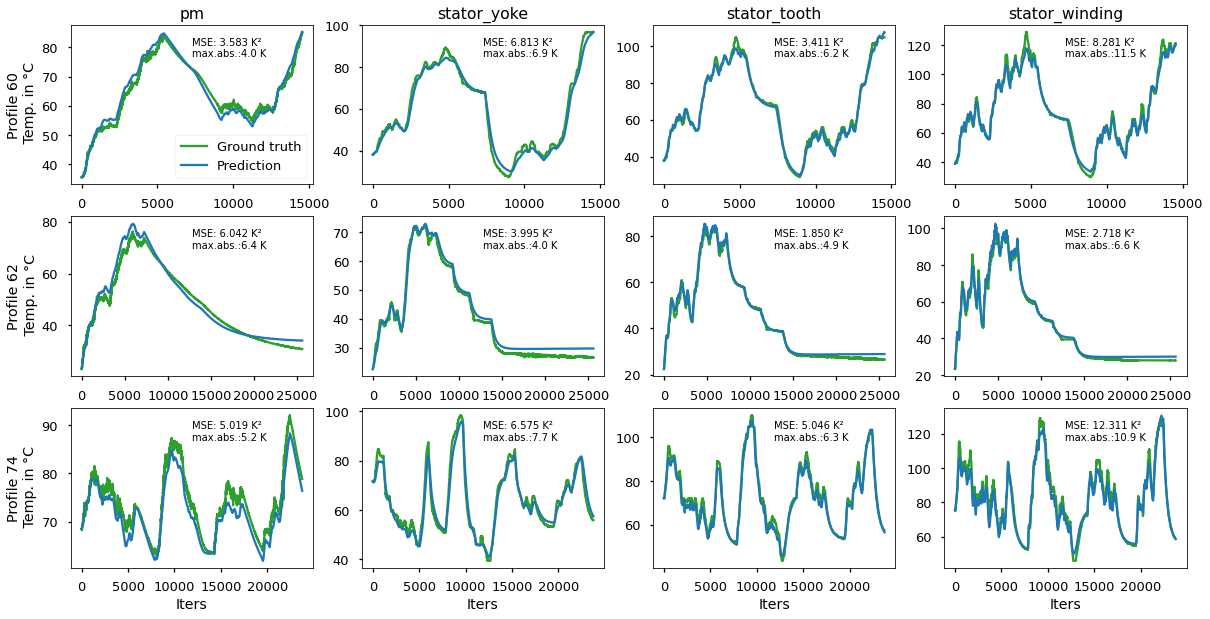

In [11]:
fig, axes = plt.subplots(len(test_profiles), len(target_cols), figsize=(20, 10))
for i, (pid, y_test) in enumerate(data.loc[data.profile_id.isin(test_profiles), target_cols + ['profile_id']].groupby('profile_id')):
    y_test *= 100
    profile_pred = pred[:len(y_test), i, :]
    for j, col in enumerate(target_cols):
        ax = axes[i, j]
        ax.plot(y_test.loc[:, col].reset_index(drop=True), color='tab:green', label='Ground truth')
        ax.plot(profile_pred[:, j], color='tab:blue', label='Prediction')
        ax.text(x=0.5, y=0.8, 
                s=f'MSE: {((profile_pred[:, j] - y_test.loc[:, col])**2).sum() / len(profile_pred):.3f} K²\nmax.abs.:{(profile_pred[:, j]-y_test.loc[:, col]).abs().max():.1f} K',
                transform=ax.transAxes)
        if j == 0:
            ax.set_ylabel(f'Profile {pid}\n Temp. in °C')
            if i == 0:
                ax.legend()
        if i == len(test_profiles) - 1:
            ax.set_xlabel(f'Iters')
        elif i == 0:
            ax.set_title(col)
        

The performance that is seen here by the hybridization of LPTNs with neural networks is unprecedented and not achievable by pure LPTN or pure black-box ML models.